# 序列模型

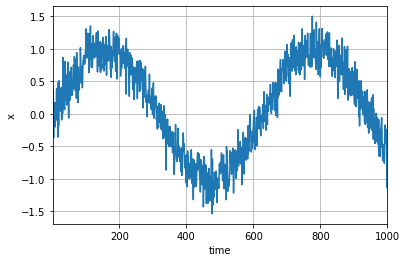

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import My_utils

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
My_utils.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## 生成数据对

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = My_utils.load_array((features[:n_train], labels[:n_train]), batch_size, is_Train=True)

In [3]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weight)
    return net

loss = nn.MSELoss(reduction='none')

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {My_utils.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, epochs=5, lr=0.01)

epoch 1, loss: 0.054507
epoch 2, loss: 0.052499
epoch 3, loss: 0.050114
epoch 4, loss: 0.049500
epoch 5, loss: 0.049900


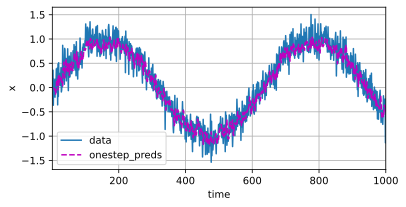

In [5]:
onestep_preds = net(features)
My_utils.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', xlim=[1, 1000], figsize=(6, 3), legend=['data', 'onestep_preds'])

## 单步预测和多步预测的区别
之前的预测都是用feature的4个值进行预测，feature包括0-1000的所有值，但是实际情况常常是当前的数据只到600，因此600之后的数据的预测要基于在其之前的预测的数据，即605的数据基于的是601-604数据进行预测，而这四个数据是我们预测出来的，而不应该是feature提供的。

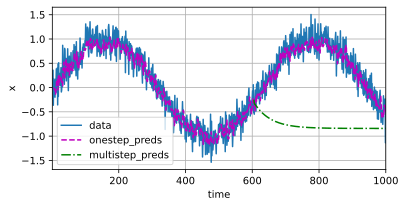

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape(1, -1))
My_utils.plot([time, time[tau:], time[n_train + tau:]], [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x', legend=['data', 'onestep_preds', 'multistep_preds'], xlim=[1, 1000], figsize=(6, 3))

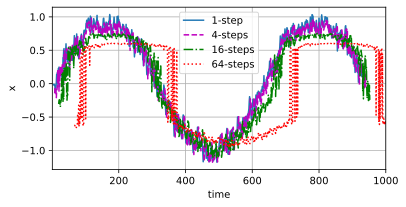

In [7]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - max_steps - tau + 1]
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)
My_utils.plot([time[tau + i - 1: T - max_steps + i] for i in steps], 
              [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x', legend=['1-step', '4-steps', '16-steps', '64-steps'], xlim=[1, 1000], figsize=(6, 3))